In [3]:
import numpy as np;
import pandas as pd;
import json
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import pos_tag
from nltk import chunk
from nltk import StanfordNERTagger
from nltk import StanfordPOSTagger
import joblib
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentAnalyzer
import re, string
import matplotlib as mlp
from matplotlib import pyplot as plt
import seaborn as sns


In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**1 - Extraction**

In [3]:
with open('10000_tweets.json', 'r', encoding='utf8') as in_file:
    f = open("new_json.json", "w", encoding='utf8')
    for line in in_file:
        if(not line.strip().startswith('/*')):
            if(":" in line):
                if(line.split(':')[1].strip().startswith('"') or line.split(":")[1].strip() in '[]{}'):
                    f.write(line)
            else:
                f.write(line)
        else:
            f.write(',')
    f.close()

In [6]:
with open(r'C:\Users\Dani\Desktop\Big Data Assignment 2\new_json.json', encoding='utf-8') as f:
    df = pd.read_json(f)


In [28]:
tweets = pd.DataFrame(df)

In [29]:
tweets = pd.DataFrame({
    'postedTime':tweets['postedTime'],
    'actor':df['actor'],
    'object':tweets['object'],
    'gnip':tweets['gnip'],
    'text':tweets['text'],
})
tweets.head()

,postedTime,actor,object,gnip,text
0,2016-04-01T00:00:01.000Z,"{'objectType': 'person', 'id': '10243188921458...","{'objectType': 'note', 'id': '1345715690143449...","{'matching_rules': [{'value': 'bio_location: ""...",CONGRATULATIONS Suzie Walker on both your beau...
1,2016-04-01T00:00:01.000Z,"{'objectType': 'person', 'id': '1024397578801'...","{'objectType': 'note', 'id': '1345715690141306...","{'matching_rules': [{'value': 'bio_location: ""...","Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p..."
2,2016-04-01T00:00:01.000Z,"{'objectType': 'person', 'id': '10243126525057...","{'objectType': 'note', 'id': '1345715690140849...","{'matching_rules': [{'value': 'bio_location: ""...",Join us @ the Hilton Sydney 2 learn how 2 make...
3,2016-04-01T00:00:03.000Z,"{'objectType': 'person', 'id': '10243295689843...","{'objectType': 'note', 'id': '1345715690148764...","{'matching_rules': [{'value': 'bio_location: ""...",Say Hello to this Gorgeous Gingham Dress! \n\n...
4,2016-04-01T00:00:00.000Z,"{'objectType': 'person', 'id': '1024318064228'...","{'objectType': 'note', 'id': '1345715690137900...","{'matching_rules': [{'value': 'bio_location: ""...",Register for #Convergence2016 to hear@ChelleMe...


**2 - Enrichment**

In [30]:
import datetime
tweets['postedTime'] = tweets.apply(lambda x: datetime.datetime.strptime(x['postedTime'],"%Y-%m-%dT%H:%M:%S.%fZ"), axis=1)
tweets['postedDate'] = tweets.apply(lambda x:str(x['postedTime']).split(' ')[0], axis=1)
tweets['postedTime'] = tweets.apply(lambda x:str(x['postedTime']).split(' ')[1], axis=1)
tweets['id'] = tweets.apply(lambda x:x['actor']['id'], axis=1)
tweets['userTimezone'] = tweets.apply(lambda x:x['actor'], axis=1)
tweets['language'] = tweets.apply(lambda x:getLanguage(x), axis=1)
tweets['location'] = tweets.apply(lambda x:getLocation(x), axis=1)
tweets['latitude'] = tweets.apply(lambda x:getLatitude(x), axis=1)
tweets['longitude'] = tweets.apply(lambda x:getLongitude(x), axis=1)
tweets.drop(['object', 'actor', 'gnip'], inplace=True, axis=1)
tweets = tweets.reindex(columns=['id', 'userTimezone', 'postedDate', 'postedTime', 'text', 'location', 'language', 'latitude', 'longitude', 'text_clean'])
tweets.head()

,id,userTimezone,postedDate,postedTime,text,location,language,latitude,longitude
0,10243188921458,"{'objectType': 'person', 'id': '10243188921458...",2016-04-01,00:00:01,CONGRATULATIONS Suzie Walker on both your beau...,Australia,en,135.00000,-25.00000
1,1024397578801,"{'objectType': 'person', 'id': '1024397578801'...",2016-04-01,00:00:01,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",Australia,en,145.00000,-37.00000
2,10243126525057,"{'objectType': 'person', 'id': '10243126525057...",2016-04-01,00:00:01,Join us @ the Hilton Sydney 2 learn how 2 make...,New Zealand,en,174.00000,-42.00000
3,102432956898436,"{'objectType': 'person', 'id': '10243295689843...",2016-04-01,00:00:03,Say Hello to this Gorgeous Gingham Dress! \n\n...,Australia,en,135.00000,-25.00000
4,1024318064228,"{'objectType': 'person', 'id': '1024318064228'...",2016-04-01,00:00:00,Register for #Convergence2016 to hear@ChelleMe...,Australia,en,149.12807,-35.28346


In [36]:
tweets['text_clean'] = tweets.apply(lambda x:cleanTweetText(x['text'].lower()), axis=1)
tweets.head()

,id,userTimezone,postedDate,postedTime,text,location,language,latitude,longitude,text_clean
0,10243188921458,"{'objectType': 'person', 'id': '10243188921458...",2016-04-01,00:00:01,CONGRATULATIONS Suzie Walker on both your beau...,Australia,en,135.00000,-25.00000,congratulations suzie walker on both your beau...
1,1024397578801,"{'objectType': 'person', 'id': '1024397578801'...",2016-04-01,00:00:01,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",Australia,en,145.00000,-37.00000,wantirna vic au 1100 am temp 198c rh 67pct win...
2,10243126525057,"{'objectType': 'person', 'id': '10243126525057...",2016-04-01,00:00:01,Join us @ the Hilton Sydney 2 learn how 2 make...,New Zealand,en,174.00000,-42.00000,join us the hilton sydney 2 learn how 2 make ...
3,102432956898436,"{'objectType': 'person', 'id': '10243295689843...",2016-04-01,00:00:03,Say Hello to this Gorgeous Gingham Dress! \n\n...,Australia,en,135.00000,-25.00000,say hello to this gorgeous gingham dress \n\np...
4,1024318064228,"{'objectType': 'person', 'id': '1024318064228'...",2016-04-01,00:00:00,Register for #Convergence2016 to hear@ChelleMe...,Australia,en,149.12807,-35.28346,register for convergence2016 to hear talk abou...


In [47]:
from nltk.tokenize import word_tokenize
import nltk
tweets['tokens'] = tweets.apply(lambda x:word_tokenize(x['text_clean']), axis=1)
tweets['hashtags'] = tweets.apply(lambda x:getHashtags(x['text']), axis=1)
tweets['partsOfSpeech'] = tweets.apply(lambda x:getPartsOfSpeech(x['text_clean']), axis=1)
save_tweets(tweets, 'tweets')
tweets.head()

,id,userTimezone,postedDate,postedTime,text,location,language,latitude,longitude,text_clean,tokens,hashtags,partsOfSpeech,entities,peopleCount,pepole,organizations,nouns,verbs,topics
0,10243188921458,"{'objectType': 'person', 'id': '10243188921458...",2016-04-01,00:00:01,CONGRATULATIONS Suzie Walker on both your beau...,Australia,en,135.00000,-25.00000,congratulations suzie walker on both your beau...,"[congratulations, suzie, walker, on, both, you...",,"[(congratulations, NNS), (suzie, VBP), (walker...","[(congratulations, O), (suzie, O), (walker, O)...",0,[],[],5,0,"[little, walker, suzie, fantastic, congratulat..."
1,1024397578801,"{'objectType': 'person', 'id': '1024397578801'...",2016-04-01,00:00:01,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",Australia,en,145.00000,-37.00000,wantirna vic au 1100 am temp 198c rh 67pct win...,"[wantirna, vic, au, 1100, am, temp, 198c, rh, ...",[vicweather],"[(wantirna, NN), (vic, NN), (au, NN), (1100, C...","[(wantirna, O), (vic, O), (au, O), (1100, O), ...",0,[],[],11,0,"[today, vicweather, 67pct, 10143, steady, want..."
2,10243126525057,"{'objectType': 'person', 'id': '10243126525057...",2016-04-01,00:00:01,Join us @ the Hilton Sydney 2 learn how 2 make...,New Zealand,en,174.00000,-42.00000,join us the hilton sydney 2 learn how 2 make ...,"[join, us, the, hilton, sydney, 2, learn, how,...",,"[(join, NN), (us, PRP), (the, DT), (hilton, NN...","[(join, O), (us, O), (the, O), (hilton, ORGANI...",0,[],[],6,0,"[hilton, pervasive, sydney, analytics, learn, ..."
3,102432956898436,"{'objectType': 'person', 'id': '10243295689843...",2016-04-01,00:00:03,Say Hello to this Gorgeous Gingham Dress! \n\n...,Australia,en,135.00000,-25.00000,say hello to this gorgeous gingham dress \n\np...,"[say, hello, to, this, gorgeous, gingham, dres...",,"[(say, VB), (hello, NN), (to, TO), (this, DT),...","[(say, O), (hello, O), (to, O), (this, O), (go...",0,[],[],7,1,"[perfect, gorgeous, hello, gingham, originally..."
4,1024318064228,"{'objectType': 'person', 'id': '1024318064228'...",2016-04-01,00:00:00,Register for #Convergence2016 to hear@ChelleMe...,Australia,en,149.12807,-35.28346,register for convergence2016 to hear talk abou...,"[register, for, convergence2016, to, hear, tal...",[Convergence2016],"[(register, NN), (for, IN), (convergence2016, ...","[(register, O), (for, O), (convergence2016, O)...",0,[],[],5,2,"[manage, digital, change, convergence2016, reg..."


In [51]:
tweets['entities_2'] = tweets.apply(lambda x:getEntities(x['text']), axis=1)

In [ ]:
tweets['nouns'] = tweets.apply(lambda x:getPartOfSpeechCount(x['partsOfSpeech'], 'NN'), axis=1)
tweets['verbs'] = tweets.apply(lambda x:getPartOfSpeechCount(x['partsOfSpeech'], 'VB'), axis=1)
tweets['topics'] = tweets.apply(lambda x:getTweetTopics(x['text_clean']), axis=1)
save_tweets(tweets, 'tweets2')
tweets.head()

In [64]:
tweets['peopleCount'] = tweets.apply(lambda x:getEntitiesType(x['entities_2'], 'PERSON')[0], axis=1)
tweets['people'] = tweets.apply(lambda x:getEntitiesType(x['entities_2'], 'PERSON')[1], axis=1)
tweets['organizations'] = tweets.apply(lambda x:getEntitiesType(x['entities_2'], 'ORGANIZATION')[1], axis=1)

In [76]:
tweets['entities'] = tweets['entities_2']
tweets['text'] = tweets['text_clean']

tweets.head()

,id,userTimezone,postedDate,postedTime,text,location,language,latitude,longitude,text_clean,...,partsOfSpeech,entities,peopleCount,pepole,organizations,nouns,verbs,topics,people,entities_2
0,10243188921458,"{'objectType': 'person', 'id': '10243188921458...",2016-04-01,00:00:01,congratulations suzie walker on both your beau...,Australia,en,135.00000,-25.00000,congratulations suzie walker on both your beau...,...,"[(congratulations, NNS), (suzie, VBP), (walker...","[(CONGRATULATIONS, O), (Suzie, PERSON), (Walke...",2,[],[],6,1,"[little, walker, suzie, fantastic, congratulat...","[Suzie, Walker]","[(CONGRATULATIONS, O), (Suzie, PERSON), (Walke..."
1,1024397578801,"{'objectType': 'person', 'id': '1024397578801'...",2016-04-01,00:00:01,wantirna vic au 1100 am temp 198c rh 67pct win...,Australia,en,145.00000,-37.00000,wantirna vic au 1100 am temp 198c rh 67pct win...,...,"[(wantirna, NN), (vic, NN), (au, NN), (1100, C...","[(Wantirna, PERSON), (,, O), (VIC, PERSON), (,...",2,[],[],12,1,"[today, vicweather, 67pct, 10143, steady, want...","[Wantirna, VIC]","[(Wantirna, PERSON), (,, O), (VIC, PERSON), (,..."
2,10243126525057,"{'objectType': 'person', 'id': '10243126525057...",2016-04-01,00:00:01,join us the hilton sydney 2 learn how 2 make ...,New Zealand,en,174.00000,-42.00000,join us the hilton sydney 2 learn how 2 make ...,...,"[(join, NN), (us, PRP), (the, DT), (hilton, NN...","[(Join, O), (us, O), (@, O), (the, O), (Hilton...",0,[],"[Hilton, Sydney]",7,1,"[hilton, pervasive, sydney, analytics, learn, ...",[],"[(Join, O), (us, O), (@, O), (the, O), (Hilton..."
3,102432956898436,"{'objectType': 'person', 'id': '10243295689843...",2016-04-01,00:00:03,say hello to this gorgeous gingham dress \n\np...,Australia,en,135.00000,-25.00000,say hello to this gorgeous gingham dress \n\np...,...,"[(say, VB), (hello, NN), (to, TO), (this, DT),...","[(Say, O), (Hello, O), (to, O), (this, O), (Go...",0,[],[],7,1,"[perfect, gorgeous, hello, gingham, originally...",[],"[(Say, O), (Hello, O), (to, O), (this, O), (Go..."
4,1024318064228,"{'objectType': 'person', 'id': '1024318064228'...",2016-04-01,00:00:00,register for convergence2016 to hear talk abou...,Australia,en,149.12807,-35.28346,register for convergence2016 to hear talk abou...,...,"[(register, NN), (for, IN), (convergence2016, ...","[(Register, O), (for, O), (#, O), (Convergence...",1,[],[],5,2,"[manage, digital, change, register, convergenc...",[ChelleMelbourne],"[(Register, O), (for, O), (#, O), (Convergence..."


In [100]:
tweets['userTimezone'] = tweets.apply(lambda x:getUserTimezone(x), axis=1)
tweets.drop(['entities_2', 'pepole', 'text_clean'], inplace=True, axis=1)
tweets.head()

,id,userTimezone,postedDate,postedTime,text,location,language,latitude,longitude,tokens,hashtags,partsOfSpeech,entities,peopleCount,organizations,nouns,verbs,topics,people
0,10243188921458,Sydney,2016-04-01,00:00:01,congratulations suzie walker on both your beau...,Australia,en,135.00000,-25.00000,"[congratulations, suzie, walker, on, both, you...",,"[(congratulations, NNS), (suzie, VBP), (walker...","[(CONGRATULATIONS, O), (Suzie, PERSON), (Walke...",2,[],6,1,"[little, walker, suzie, fantastic, congratulat...","[Suzie, Walker]"
1,1024397578801,Melbourne,2016-04-01,00:00:01,wantirna vic au 1100 am temp 198c rh 67pct win...,Australia,en,145.00000,-37.00000,"[wantirna, vic, au, 1100, am, temp, 198c, rh, ...",[vicweather],"[(wantirna, NN), (vic, NN), (au, NN), (1100, C...","[(Wantirna, PERSON), (,, O), (VIC, PERSON), (,...",2,[],12,1,"[today, vicweather, 67pct, 10143, steady, want...","[Wantirna, VIC]"
2,10243126525057,Sydney,2016-04-01,00:00:01,join us the hilton sydney 2 learn how 2 make ...,New Zealand,en,174.00000,-42.00000,"[join, us, the, hilton, sydney, 2, learn, how,...",,"[(join, NN), (us, PRP), (the, DT), (hilton, NN...","[(Join, O), (us, O), (@, O), (the, O), (Hilton...",0,"[Hilton, Sydney]",7,1,"[hilton, pervasive, sydney, analytics, learn, ...",[]
3,102432956898436,Brisbane,2016-04-01,00:00:03,say hello to this gorgeous gingham dress \n\np...,Australia,en,135.00000,-25.00000,"[say, hello, to, this, gorgeous, gingham, dres...",,"[(say, VB), (hello, NN), (to, TO), (this, DT),...","[(Say, O), (Hello, O), (to, O), (this, O), (Go...",0,[],7,1,"[perfect, gorgeous, hello, gingham, originally...",[]
4,1024318064228,Canberra,2016-04-01,00:00:00,register for convergence2016 to hear talk abou...,Australia,en,149.12807,-35.28346,"[register, for, convergence2016, to, hear, tal...",[Convergence2016],"[(register, NN), (for, IN), (convergence2016, ...","[(Register, O), (for, O), (#, O), (Convergence...",1,[],5,2,"[manage, digital, change, register, convergenc...",[ChelleMelbourne]


In [57]:
import os
os.environ['CLASSPATH'] = r'C:\Users\Dani\Desktop\Big Data Assignment 2\stanford-ner.jar'
os.environ['PATH'] = r'C:\Users\Dani\Desktop\Big Data Assignment 2\gensim-4.1.2'


In [9]:

def getLanguage(x):
    x = json.dumps(tweets['userTimeZone'][x.name])
    x = json.loads(x)
    try:
        return x['languages'][0]
    except:
        return np.nan

def getLocation(x):
    x = json.dumps(tweets['gnip'][x.name])
    x = json.loads(x)

    try:
        value = x['profileLocations'][0]['address']['country']
        return value
    except:
        return np.nan

def getLatitude(x):
    x = json.dumps(tweets['gnip'][x.name])
    x = json.loads(x)
    try:
        value = x['profileLocations'][0]['geo']['coordinates'][0]
    except:
        value = np.nan
    return value

def getLongitude(x):
    x = json.dumps(tweets['gnip'][x.name])
    x = json.loads(x)
    try:
        value = x['profileLocations'][0]['geo']['coordinates'][1]
    except:
        value = np.nan
    return value

def getUserId(x):
    x = json.dumps(tweets['actor'][x.name])
    x = json.loads(x)
    try:
        value = x['id']
    except:
        value = np.nan
    return value

def getUserTimezone(x):
    x = json.dumps(tweets['userTimezone'][x.name])
    x = json.loads(x)
    try:
        value = x['twitterTimeZone']
    except:
        value = np.nan
    return value


def getPartsOfSpeech(x):
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.tag import pos_tag

    sent = word_tokenize(x)
    sent = nltk.pos_tag(sent)
    return sent


def extractEntites2(listOfTuples, x):
    with open(x, 'w') as f:
        f.write(listOfTuples)

def extractEntities(listOfTuples,y):
    with open(y, 'w') as f:
        for i, j in enumerate(listOfTuples):
            if(j[1] not in 'O'):
                f.write(j[0] + ' ' + j[1]+'\n')
    f.close()


def getEntities(x):
    _model_filename = r'C:\Users\Dani\Desktop\Big Data Assignment 2\english.all.3class.distsim.crf.ser.gz'
    _path_to_jar = r'C:\Users\Dani\Desktop\Big Data Assignment 2\stanford-ner.jar'
    st = StanfordNERTagger(_model_filename)

    return st.tag(word_tokenize(x))

def getHashtags(x):
    tags = []
    for word in x.split():
        if(word[0]=='#'):
            tags.append(word[1:])
    if(len(tags) > 0):
        return tags
    else:
        return ''

def getPartOfSpeechCount(tupleList, part):
    count = 0
    for i, j in enumerate(tupleList):
        if(part in str(j)):
            count = count + 1
    return count

def getEntitiesType(tupleList, type):
    entities = []
    count = 0
    for i, j in list(tupleList):
        if(j == type):
            entities.append(i)
            count = count + 1
    return count, entities

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def getTokens(text):
    en_stop = set(nltk.corpus.stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

def getTweetTopics(text):
    en_stop = 10
    #vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')
    #tf = vectorizer.fit_transform(text).toarray()
    #tf_feature_names = vectorizer.get_feature_names()
    try:
        model = LatentDirichletAllocation(n_components=10)
        model.fit(getCountVectors(text)[1])
        topics = []
        for index, topic in enumerate(model.components_):
            topics.append([getCountVectors(text)[0][i] for i in topic.argsort()[-15:]])
        all_topics = []
        for i, j in enumerate(topics):
            all_topics = all_topics + j
        return list(set(all_topics))
    except:
        return ''

def getCountVectors(text):
    vectorizer = CountVectorizer(max_df=1, min_df=1, stop_words='english')
    text = getTokens(text)
    tf = vectorizer.fit_transform(text).toarray()
    tf_feature_names = vectorizer.get_feature_names()
    return tf_feature_names, tf

def cleanTweetText(x):
    return re.sub(r"(@[A-Za-z0–9_]+)|[^\w\s]|#|http\S+", "", x)

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence


def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

def save_tweets(x, fname):
    x.to_csv('{}.csv'.format(fname))


In [73]:
tweets.columns

Index(['id', 'userTimezone', 'postedDate', 'postedTime', 'text', 'location',
       'language', 'latitude', 'longitude', 'text_clean', 'tokens', 'hashtags',
       'partsOfSpeech', 'entities', 'peopleCount', 'pepole', 'organizations',
       'nouns', 'verbs', 'topics', 'people', 'entities_2'],
      dtype='object')

In [ ]:
tweets.drop(['partsOfSpeech', 'entities', 'tokens'], inplace=True,  axis=1)

**Sentiment Analysis**

In [58]:
nltk.download('twitter_samples')
nltk.download('stopwords')


[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords


nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')



In [11]:
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, ))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [59]:
positive_cleaned_tokens_list[1]

['hey',
 'james',
 'how',
 'odd',
 ':/',
 'please',
 'call',
 'our',
 'contact',
 'centre',
 'on',
 '02392441234',
 'and',
 'we',
 'will',
 'be',
 'able',
 'to',
 'assist',
 'you',
 ':)',
 'many',
 'thanks']

In [34]:
all_pos_words = get_all_words(positive_cleaned_tokens_list)
all_neg_words = get_all_words(negative_cleaned_tokens_list)


<generator object get_all_words at 0x0000028E08239E48>

In [35]:
from nltk import FreqDist

freq_dist_pos = FreqDist(all_pos_words)
freq_dis_neg = FreqDist(all_neg_words)

In [36]:
positive_dist = freq_dist_pos.most_common(10)
neg_dist = freq_dis_neg.most_common(10)
neg_dist

[(':(', 4585),
 (':-(', 501),
 ("i'm", 343),
 ('...', 332),
 ('get', 325),
 ('miss', 291),
 ('go', 275),
 ('please', 275),
 ('want', 246),
 ('like', 218)]

In [37]:
positive_dist_df = pd.DataFrame({
    'word': [x[0] for x in positive_dist],
    'count': [x[1] for x in positive_dist]
})
positive_dist_df

,word,count
0,:),3691
1,you,1463
2,be,1189
3,to,1093
4,i,1093
5,the,1086
6,a,934
7,for,771
8,and,706
9,:-),701


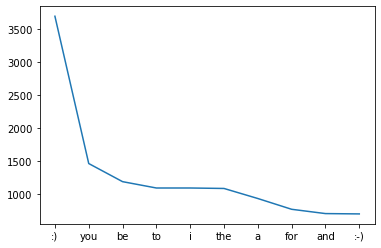

In [49]:
plt.plot(positive_dist_df['word'], positive_dist_df['count'])

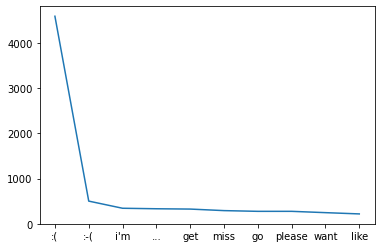

In [50]:
negative_dist_df = pd.DataFrame({
    'word': [x[0] for x in neg_dist],
    'count': [x[1] for x in neg_dist]
})
plt.plot(negative_dist_df['word'], negative_dist_df['count'])

In [38]:
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [22]:
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

In [23]:
import random

positive_dataset = [(tweet_dict, "Positive") for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative") for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

In [24]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

In [26]:
print("Accuracy is:", classify.accuracy(classifier, test_data))

Accuracy is: 0.9983333333333333


In [60]:
def getSentiment(tweet):
    tokens = remove_noise(word_tokenize(tweet['text']))
    return classifier.classify(dict([token, True] for token in tokens))

In [27]:
tweets['sentiment'].value_counts()

Positive    9553
Negative     447
Name: sentiment, dtype: int64

In [171]:
tweets['sentiment'] = tweets.apply(lambda x:getSentiment(x), axis=1)
tweets.head()

,id,userTimezone,postedDate,postedTime,text,location,language,latitude,longitude,tokens,hashtags,partsOfSpeech,entities,peopleCount,organizations,nouns,verbs,topics,people,sentiment
0,10243188921458,Sydney,2016-04-01,00:00:01,congratulations suzie walker on both your beau...,Australia,en,135.00000,-25.00000,"[congratulations, suzie, walker, on, both, you...",,"[(congratulations, NNS), (suzie, VBP), (walker...","[(CONGRATULATIONS, O), (Suzie, PERSON), (Walke...",2,[],6,1,"[little, walker, suzie, fantastic, congratulat...","[Suzie, Walker]",Positive
1,1024397578801,Melbourne,2016-04-01,00:00:01,wantirna vic au 1100 am temp 198c rh 67pct win...,Australia,en,145.00000,-37.00000,"[wantirna, vic, au, 1100, am, temp, 198c, rh, ...",[vicweather],"[(wantirna, NN), (vic, NN), (au, NN), (1100, C...","[(Wantirna, PERSON), (,, O), (VIC, PERSON), (,...",2,[],12,1,"[today, vicweather, 67pct, 10143, steady, want...","[Wantirna, VIC]",Positive
2,10243126525057,Sydney,2016-04-01,00:00:01,join us the hilton sydney 2 learn how 2 make ...,New Zealand,en,174.00000,-42.00000,"[join, us, the, hilton, sydney, 2, learn, how,...",,"[(join, NN), (us, PRP), (the, DT), (hilton, NN...","[(Join, O), (us, O), (@, O), (the, O), (Hilton...",0,"[Hilton, Sydney]",7,1,"[hilton, pervasive, sydney, analytics, learn, ...",[],Positive
3,102432956898436,Brisbane,2016-04-01,00:00:03,say hello to this gorgeous gingham dress \n\np...,Australia,en,135.00000,-25.00000,"[say, hello, to, this, gorgeous, gingham, dres...",,"[(say, VB), (hello, NN), (to, TO), (this, DT),...","[(Say, O), (Hello, O), (to, O), (this, O), (Go...",0,[],7,1,"[perfect, gorgeous, hello, gingham, originally...",[],Positive
4,1024318064228,Canberra,2016-04-01,00:00:00,register for convergence2016 to hear talk abou...,Australia,en,149.12807,-35.28346,"[register, for, convergence2016, to, hear, tal...",[Convergence2016],"[(register, NN), (for, IN), (convergence2016, ...","[(Register, O), (for, O), (#, O), (Convergence...",1,[],5,2,"[manage, digital, change, register, convergenc...",[ChelleMelbourne],Positive


In [173]:
save_tweets(tweets, 'tweets_sentiment')

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

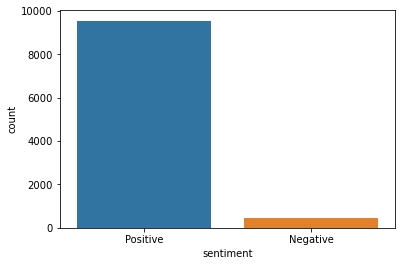

In [28]:
sns.countplot(x ='sentiment', data = tweets)

# Show the plot
plt.show()

In [51]:
all_positives = freq_dist_pos.most_common(10)
all_negatives = freq_dis_neg.most_common(10)


In [52]:
data = []
for x in [all_positives,all_negatives]:
    for i, t in enumerate(x):
        data.append([t[0], t[1]])

df = pd.DataFrame(data)
df.columns=['Word','Count',]

In [53]:
df

,Word,Count
0,:),3691
1,you,1463
2,be,1189
3,to,1093
4,i,1093
5,the,1086
6,a,934
7,for,771
8,and,706
9,:-),701


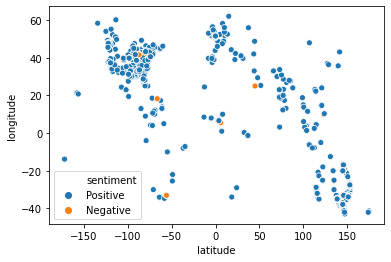

In [56]:
sns.scatterplot(data = tweets, x = "latitude", y = "longitude", hue = 'sentiment')


In [84]:

by_country = tweets.groupby(['location', 'sentiment'])

In [102]:
sentiment_by_country = tweets.groupby('location', as_index=False).agg({'sentiment':'sum'})

In [61]:
def getPositiveCount(x):
    count = str(x).count('Positive');
    return count

def getNegativeCOunt(x):
    count = str(x).count('Negative');
    return count


In [114]:
sentiment_by_country['Positive'] = sentiment_by_country.apply(lambda x:getPositiveCount(x['sentiment']), axis=1)
sentiment_by_country['Negative'] = sentiment_by_country.apply(lambda x:getNegativeCOunt(x['sentiment']), axis=1)
sentiment_by_country.drop('sentiment', inplace=True, axis=1)

In [119]:
sentiment_by_country

,location,Positive,Negative
0,Afghanistan,2,0
1,Argentina,4,0
2,Australia,6853,365
3,Bahamas,1,0
4,Benin,0,1
...,...,...,...
66,United Kingdom,61,0
67,United States,649,13
68,Uruguay,14,3
69,Venezuela (Bolivarian Republic of),3,0


Text(0.5, 1.0, 'Positive Tweets')

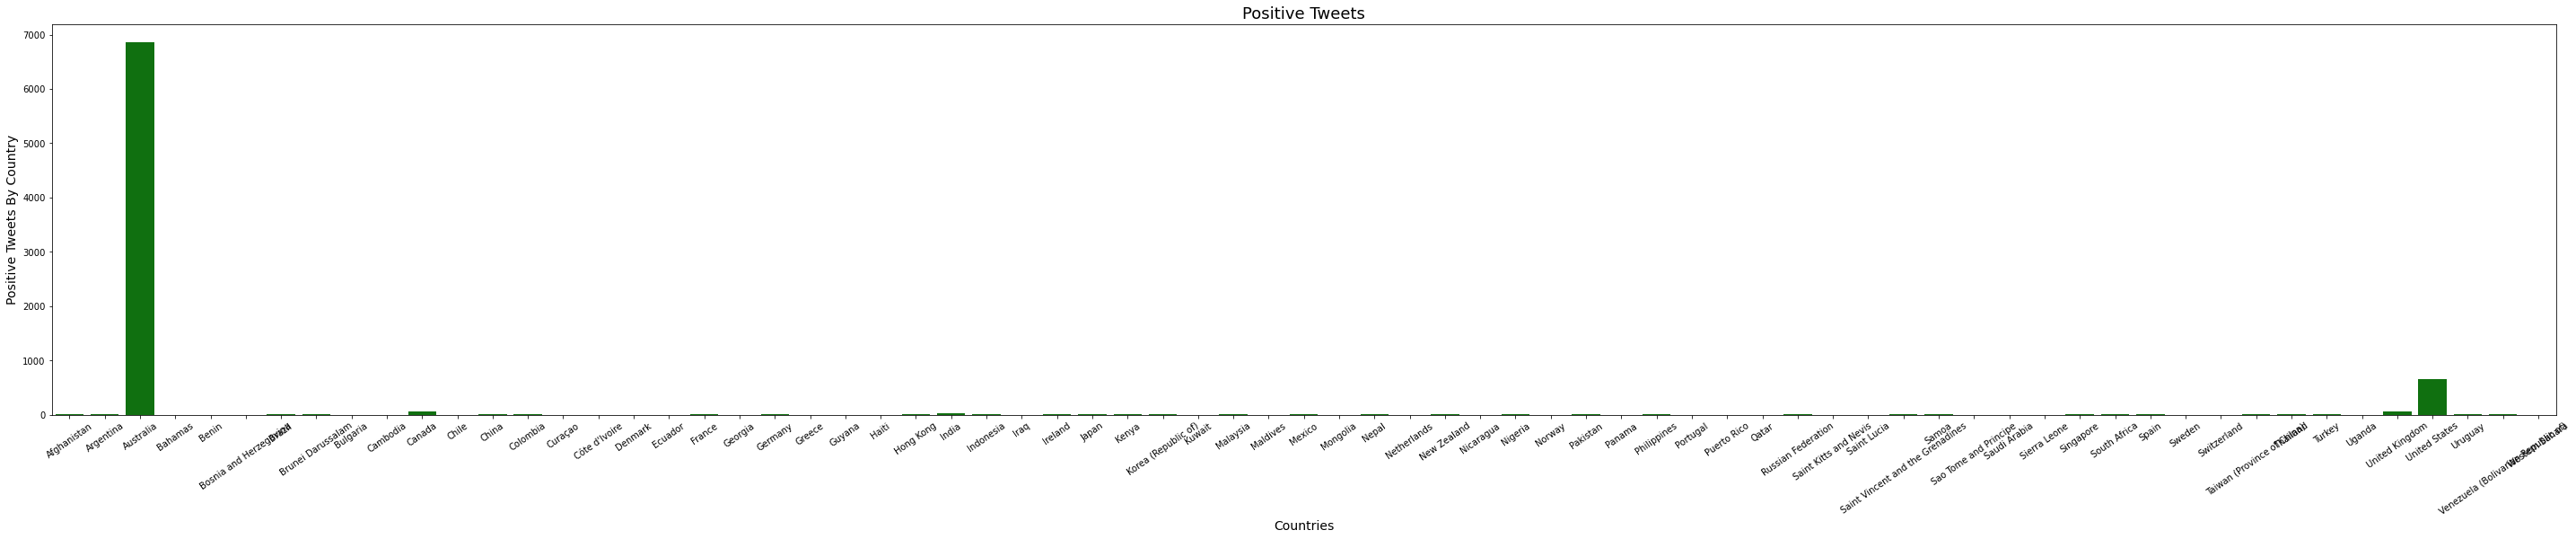

In [129]:
plt.figure(figsize=(50, 8))
sns.barplot(x="location", 
    y="Positive",
    data=sentiment_by_country,
    ci=None,
    color='green')
plt.ylabel("Positive Tweets By Country", size=14)
plt.xlabel("Countries", size=14)
plt.xticks(rotation=35)
plt.title("Positive Tweets", size=18)


Text(0.5, 1.0, 'Positive Tweets')

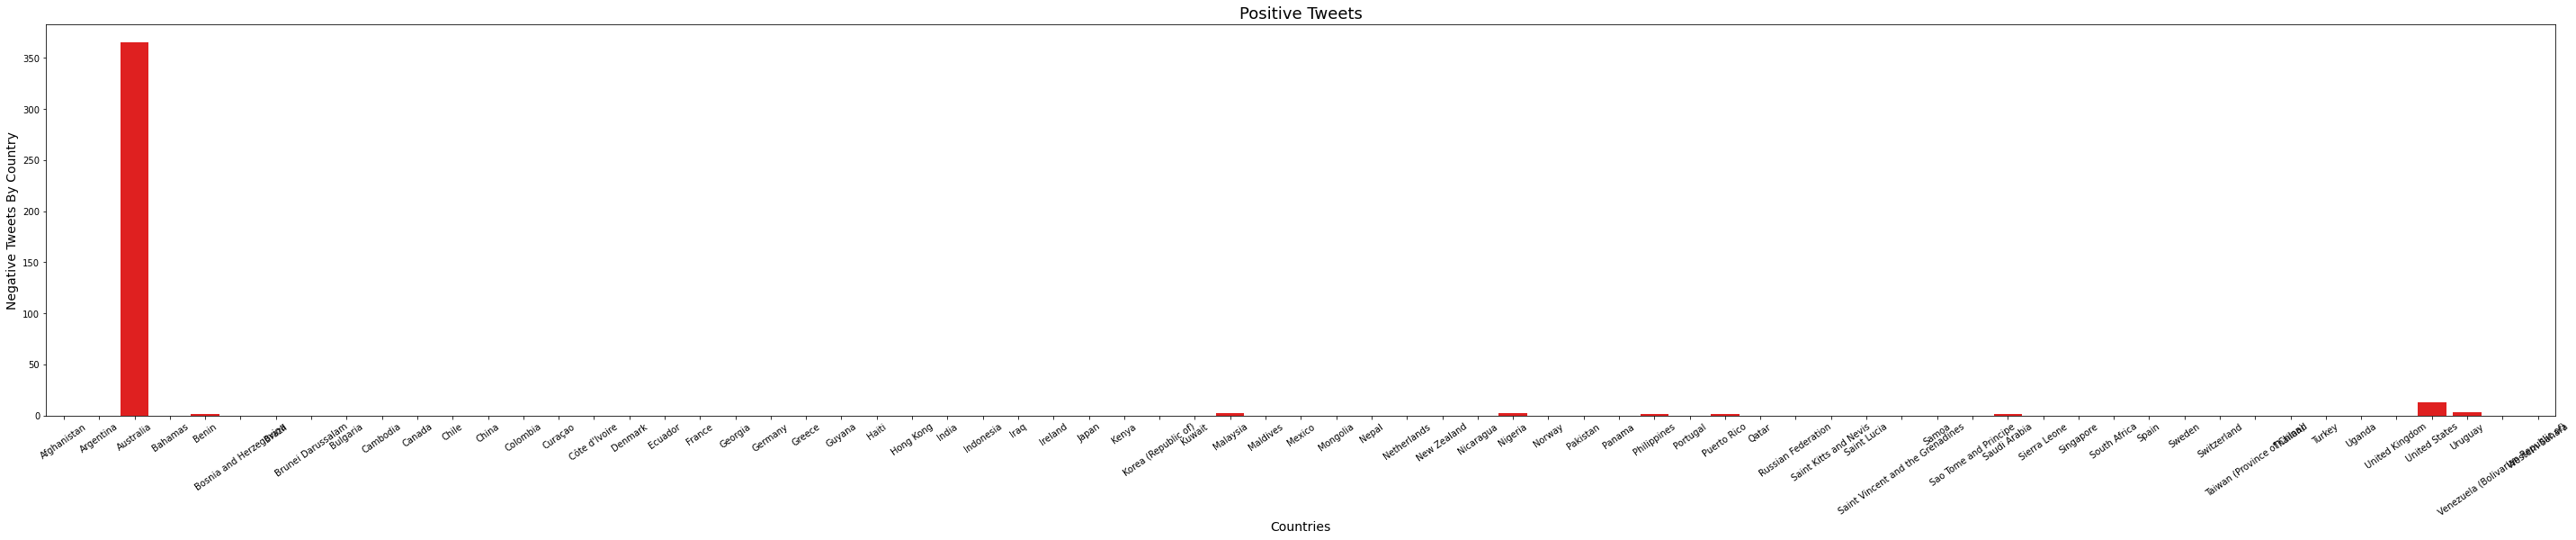

In [130]:
plt.figure(figsize=(50, 8))
sns.barplot(x="location", 
    y="Negative",
    data=sentiment_by_country,
    ci=None, color='red' )
plt.ylabel("Negative Tweets By Country", size=14)
plt.xlabel("Countries", size=14)
plt.xticks(rotation=35)
plt.title("Positive Tweets", size=18)


**Clustering**

In [7]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
getCountVectors(tweets['text'][1])[1]

array([[0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0]], dtype=int64)

In [11]:
k_means = KMeans()
tweets['text'].dropna(inplace=True)
x = TfidfVectorizer().fit_transform(tweets['text'])


In [31]:
k_result = k_means.fit_predict(x)

In [63]:
k_result

array([1, 4, 4, ..., 4, 5, 6])

In [56]:

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1)
data = tsne.fit_transform(x)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9918 samples in 0.009s...
[t-SNE] Computed neighbors for 9918 samples in 4.657s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9918
[t-SNE] Computed conditional probabilities for sample 2000 / 9918
[t-SNE] Computed conditional probabilities for sample 3000 / 9918
[t-SNE] Computed conditional probabilities for sample 4000 / 9918
[t-SNE] Computed conditional probabilities for sample 5000 / 9918
[t-SNE] Computed conditional probabilities for sample 6000 / 9918
[t-SNE] Computed conditional probabilities for sample 7000 / 9918
[t-SNE] Computed conditional probabilities for sample 8000 / 9918
[t-SNE] Computed conditional probabilities for sample 9000 / 9918
[t-SNE] Computed conditional probabilities for sample 9918 / 9918
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 129.436005
[t-SNE] KL divergence after 1000 iterations: 3.961888


In [64]:
df = pd.DataFrame()
df['center'] = k_result
df["comp-1"] = data[:,0]
df["comp-2"] = data[:,1]
df.head()

,center,comp-1,comp-2
0,1,-1.490460,2.840510
1,4,0.807684,-0.754916
2,4,-1.742495,2.491791
3,4,5.278842,-1.418275
4,5,1.877588,0.676287


In [62]:
data

array([[-1.4904597 ,  2.8405104 ],
       [ 0.80768394, -0.75491583],
       [-1.7424952 ,  2.4917905 ],
       ...,
       [ 1.9409074 ,  3.4804788 ],
       [ 1.5402524 , -2.0605423 ],
       [-2.4922295 , -2.6367755 ]], dtype=float32)

[Text(0.5, 1.0, 'T-SNE projection')]

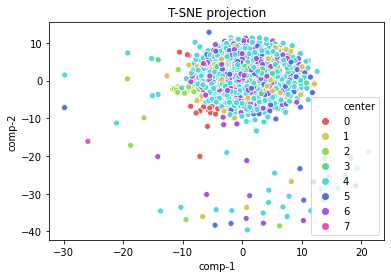

In [77]:
sns.scatterplot(x="comp-1", y="comp-2", hue='center',
                palette=sns.color_palette("hls", 8),
                data=df).set(title="T-SNE projection")
